In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc




def add_layers_anndata(process_type, input_file_h5ad, gene_annot_file, species, SRP_name, resolution, base_folder, ice_type):


    bins_bed = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.csv', names=['chr', 'start', 'end'])
    bins_bed['bin_id'] = bins_bed.index.tolist()

    bins_bed.to_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv', index=False, header=False, sep='\t')
    if species == 'human':

        blacklist_file = f'{base_folder}/BICCN_enhancer_challenege/10XMultiome/Human/hg38-blacklist.v2.bed'
    else:
        blacklist_file = f'{base_folder}/BICCN_enhancer_challenege/10XMultiome/Mouse/mm10-blacklist.v2.bed'

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {blacklist_file} -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv > {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bin_blacklist.bed")
    blacklist_bins = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bin_blacklist.bed', sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'c1', 'c2', 'c3', 'c4'])
    
    
    adata = ad.read_h5ad(f'{input_file_h5ad}', backed='r')
    
    

    data = adata.X + 0.0
    
    if resolution == '1kbp_raw':
    
        data = data.astype('float32')
        
    elif resolution == '10kbp_raw':
    
        data = data.astype('float32')
    else:
        data = data.astype('float64')
        
    np_of_rows = len(adata.obs_names.tolist())
    np_of_col = len(adata.var_names.tolist())
        
    

        
    
    nan_columns = blacklist_bins['bin_id'].tolist()

    data[:, nan_columns] = np.nan


    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()

    chrom_index_list  = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])

        chrom_index_list_intra[chrom] = index_list

    gtf = read_gtf(gene_annot_file)
    genes = gtf.df.loc[gtf.df['Feature'] == 'gene'].copy()
    genes['gene_id'] = [x.split('.')[0] for x in genes['gene_id']]
    genes['gene_id'].drop_duplicates(inplace=True)

    if not genes['Chromosome'].str.startswith('chr').any():
        genes['Chromosome'] = [f'chr{x}' for x in genes['Chromosome']]

    genes  = genes.set_index('gene_id')

    genes = genes.loc[adata.obs_names.tolist(), :]
    
    genes = genes.reset_index()



    genes[['Chromosome', 'Start', 'End', 'gene_id']].to_csv(f'{base_folder}hi_c_data_processing/data_{species}/gene_info.tsv', index=False, header=False, sep='\t')


    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {base_folder}hi_c_data_processing/data_{species}/gene_info.tsv -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv > {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/gene_info_bin_id.tsv")
    gene_id_bins = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/gene_info_bin_id.tsv', sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'st', 'end', 'gene_id', 'c4'])

    
    if process_type == 'intra':

        layer_value_list = [0, 1, 10, 100, 1000]
        layer_name_list = ['intra']*len(layer_value_list)

    if process_type == 'inter':
        layer_name_list = ['inter']
        layer_value_list = [0]

    if process_type == 'gw':
        layer_value_list = [0, 1, 10, 100, 1000]
        layer_name_list = ['intra']*len(layer_value_list)
        layer_name_list.append('inter')
        layer_value_list.append(0)



    for layer_type, dist in zip(layer_name_list, layer_value_list):
        
            adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))
        
            new_layer_name = f'{process_type}_{layer_type}_{dist}'
        
        #if new_layer_name in adata.layers:
        #    continue
        #else:

            mask = np.zeros_like(data, dtype=bool)

        

            for index, row in genes.iterrows():

                if layer_type == 'intra':
                    columns_to_mask = chrom_index_list_intra[row['Chromosome']]
                else:
                    columns_to_mask = chrom_index_list[row['Chromosome']]

                mask[index, columns_to_mask] = True

                if layer_type == 'intra':

                    start_index = gene_id_bins[gene_id_bins['gene_id'] == row['gene_id']]['bin_id'].min()

                    end_index = gene_id_bins[gene_id_bins['gene_id'] == row['gene_id']]['bin_id'].max()

                    mask[index, start_index:end_index+1]  = True

                    #for idx in [start_index, end_index]:
                    mask[index, max(0, start_index - dist):min(data.shape[1], end_index + dist+1)] = True




            data_layered = np.where(mask, np.nan, data)



            layer_name = f'{layer_type}_{dist}_raw'

            adata_l.layers[layer_name] = data_layered

            z_scores = stats.zscore(data_layered, axis=1, nan_policy='omit')


            clipped_z_scores = np.clip(z_scores, -10, 10)



            layer_name = f'{layer_type}_{dist}_z_scores'

            adata_l.layers[layer_name] = clipped_z_scores



            del z_scores
            del clipped_z_scores
            gc.collect()

            #data_plus_one = data_layered + 1

            #log_transformed_data = np.log1p(data_plus_one)

            del data_layered
            #del data_plus_one
            gc.collect()

            #layer_name = f'{process_type}_{layer_type}_{dist}_log_transformed'

            #adata.layers[layer_name] = log_transformed_data

            #z_scores = stats.zscore(log_transformed_data, axis=1, nan_policy='omit')

            #clipped_z_scores = np.clip(z_scores, -10, 10)



            #layer_name = f'{process_type}_{layer_type}_{dist}_log_transformed_z_scores'

            #adata.layers[layer_name] = clipped_z_scores

            #del z_scores
            #del log_transformed_data
            #del clipped_z_scores
            #gc.collect()
            adata_l.obs_names = adata.obs_names.tolist()
            adata_l.var_names = adata.var_names.tolist()
            
            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{layer_name}_by_allbins_max.h5ad'
            
            

            adata_l.write(outputfile_h5ad, compression="gzip")
            
            

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [ ]:
for species in ['mouse']:
    for process_type in ['intra']:
        for resolution in ['1kbp_raw']:
            base_folder = '/grid/gillis/data_norepl/lohia/'
            SRP_name='aggregates'
            ice_type='KR'
            input_file_h5ad=f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_by_allbins_max.h5ad'
            if species=='mouse':
                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
            else:
                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
            add_layers_anndata(process_type, input_file_h5ad, gene_annot_file, species, SRP_name, resolution, base_folder, ice_type)





In [2]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf
import os.path




from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc

# Assuming your data is organized as NumPy arrays
# gene_observation_matrix is genesXobservations
# gene_category_matrix is genesXcategories
# Both matrices are NumPy arrays

# Example gene_observation_matrix (5 genes, 3 observations) with NaN values


# Calculate the mean of genes for each category and observation, ignoring NaN values
def calculate_category_means_ignore_nan(gene_observation_matrix_df, gene_category_matrix_df):
    # Calculate mean for each category (axis=0) and each observation (axis=1), ignoring NaN values


    genes_intersect = gene_observation_matrix_df.index.intersection(gene_category_matrix_df.index)

    gene_observation_matrix_df =  gene_observation_matrix_df.loc[genes_intersect, :]
    gene_category_matrix_df = gene_category_matrix_df.loc[genes_intersect, :]

    gene_observation_matrix = gene_observation_matrix_df.values
    gene_category_matrix = gene_category_matrix_df.values

    category_counts = np.dot(gene_category_matrix.T, ~np.isnan(gene_observation_matrix))
    
    gene_observation_matrix_cleaned = np.nan_to_num(gene_observation_matrix, nan=0.0)
    
    category_sums = np.dot(gene_category_matrix.T, gene_observation_matrix_cleaned)
    
    # Calculate mean using only non-NaN values
    category_means = category_sums / category_counts
    
    # Replace NaN values in category_means with 0 where division by 0 occurred
    #category_means[np.isnan(category_means)] = 0.0
    
    return category_means, category_counts

# Call the function to calculate category means, ignoring NaN values


def calc_marker_matrix(marker_list,gene_list, no_of_markers=10,  drop_duplicates=True, shuffle_labels=False):
    
        
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]

        marker_list = marker_list.sort_values(by=['rank']).drop_duplicates(subset=['cell_type', 'gene'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()

        marker_list_list = []
        for group2 in all_cell_types:
                    m_tmp = marker_list[marker_list['cell_type']==group2].sort_values(by=['rank'])
                    m_tmp['rank_missing_gene'] = [x+1 for x in range(m_tmp.shape[0])]

                    marker_list_list.append(m_tmp)

        marker_list = pd.concat(marker_list_list)

        marker_list = marker_list[marker_list['rank_missing_gene']<=no_of_markers]

        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']
        marker_list['%recurrence'] = 1/marker_list['%recurrence']
        
        marker_list_copy = marker_list.copy()
        

        


        if drop_duplicates==True:

            marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc', 'rank_missing_gene']).drop_duplicates(subset=['Ensembl_gene_identifier'], keep=False)
        elif drop_duplicates=="one_copy":
            marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc', 'rank_missing_gene']).drop_duplicates(subset=['Ensembl_gene_identifier'])
        else:
            pass
        
        if shuffle_labels == True:
            

            shuffled_Ensembl_gene_identifier = marker_list['Ensembl_gene_identifier'].sample(frac=1, replace=False, random_state=42).reset_index(drop=True)


            marker_list['Ensembl_gene_identifier'] = shuffled_Ensembl_gene_identifier.tolist()
            
        else:
            pass


        df2_list = []
        for group2 in all_cell_types:
                    
                    m_tmp = marker_list[marker_list['cell_type']==group2]
                    #if number_of_times == 1:
                    df2_list.append(m_tmp)
                    #else:
                    #    random_indices = np.random.choice(m_tmp.index, size=bootstarp_size, replace=True)
                    #    bootstrap_sample = m_tmp.loc[random_indices]
                    #    df2_list.append(bootstrap_sample)

        marker_list=pd.concat(df2_list)
        marker_list_copy['rank'] = 0
        marker_list = pd.concat([marker_list, marker_list_copy])
        
        

        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

        

        return marker_table
        

#for each marker-list and input file , I can make one output file

def calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name):

        marker_list= pd.read_csv(f'{base_folder}/hi_c_data_processing/{species}_{marker_name}.csv')
        cell_type_order = marker_list['cell_type'].drop_duplicates().tolist()



        
        

        adata = ad.read_h5ad(f'{input_file_h5ad}', backed='r')
        
        np_of_col = adata.X.shape[1]
        np_of_rows = len(cell_type_order)
        
        #adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))
        
        layer_names = adata.layers.keys()
        no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
        for given_layer in layer_names:
            for drop_duplicates in [True, False]:
                    for shuf in [False, True]:
                        
                        for no_of_markers in no_of_markers_list:
                            
                                fname = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                            
                                if os.path.isfile(fname):
                                    continue
                                adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))
                        
                            
                                

                                gene_list = adata.obs_names.tolist()

                                gene_observation_matrix_dataframe = adata.to_df(layer=given_layer)

                                gene_category_dataframe = calc_marker_matrix(marker_list, gene_list, no_of_markers=no_of_markers,  drop_duplicates=drop_duplicates, shuffle_labels=shuf)

                                gene_category_dataframe = gene_category_dataframe.loc[:,cell_type_order]

                                category_means, category_counts = calculate_category_means_ignore_nan(gene_observation_matrix_dataframe, gene_category_dataframe)

                                l_n = f'mean'

                                adata_l.layers[l_n] = category_means

                                l_n = f'counts'

                                adata_l.layers[l_n] = category_counts
                                
                                #z_scores = stats.zscore(category_means, axis=0, nan_policy='omit')
                                #l_n = f'{given_layer}_{no_of_markers}_{drop_duplicates}_{shuf}_mean_scaled'
                                #adata_l.layers[l_n] = z_scores
                                
                                #z_scores = stats.zscore(category_counts, axis=0, nan_policy='omit')
                                #l_n = f'{given_layer}_{no_of_markers}_{drop_duplicates}_{shuf}_counts_scaled'
                                #adata_l.layers[l_n] = z_scores


                                adata_l.obs_names = cell_type_order
                                adata_l.var_names = adata.var_names.tolist()

                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'

                                adata_l.write(outputfile_h5ad, compression="gzip")








In [18]:

for process_type in ['intra']:
    for resolution in ['1kbp_raw']:
        for dist in [0]:
            for species in ['human']:
                for marker_name in ['brain_class', 'heart']:
                    for dist in [0,1,10,100]:
                        layer_name = 'z_scores'
                        base_folder = '/grid/gillis/data_norepl/lohia/'
                        SRP_name='aggregates'
                        ice_type='KR'
                        input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                        if species=='mouse':
                            gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                        else:
                            gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                        calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)



<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-17-3fbece317dfd>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

KeyboardInterrupt: 

In [22]:

for process_type in ['intra']:
    for resolution in ['1kbp_raw']:
        for dist in [0,1,10,100]:
            for species in ['mouse', 'human']:
                for marker_name in ['brain_class']:
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)



<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category

In [ ]:
for process_type in ['intra']:
    for resolution in ['1kbp_raw']:
        for dist in [0,1,10,100, 1000]:
            for species in ['human']:
                for marker_name in ['brain_class','brain_heart']:
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: DtypeWarning: Columns (13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-21-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / categ

In [3]:
for process_type in ['intra']:
    for resolution in ['1kbp_raw']:
        for dist in [1000]:
            for species in ['human', 'mouse']:
                for marker_name in ['brain_class']:
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)



<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-7c680bb139e5>:57: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

In [25]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


#egad function

import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
import os.path




def calculate_pearson_correlation(df, df_b, corr_method):
    # Perform bin intersection
    bins_intersect = set(df.columns.tolist()).intersection(set(df_b.columns.tolist()))
    df = df.loc[:, bins_intersect]
    #df = df.fillna(0)
    #df_b = df_b.fillna(0)
    df_b = df_b.loc[:, bins_intersect]


    # Z-score normalization
    df_b_z = stats.zscore(df_b, axis=0, nan_policy='omit')
    df_b_z = pd.DataFrame(df_b_z, index=df_b.index.tolist(), columns=df_b.columns)
    df_b_z['cell_type'] = df_b_z.index.tolist()
    df_b_z = df_b_z.set_index(['cell_type'])

    df_z = stats.zscore(df, axis=0, nan_policy='omit')
    df_z = pd.DataFrame(df_z, index=df.index.tolist(), columns=df.columns)
    df_z['cell_type'] = df_z.index.tolist()
    df_z['cell_type'] = [x + '_hic' for x in df_z['cell_type']]
    df_z = df_z.set_index(['cell_type'])
    

    # Concatenate dataframes
    #print (df_b_z)
    #print (df_z)
    #print (df_b_z, df_z)
    df_corr = pd.concat([df_b_z, df_z], axis=0)

    
    
    #df_corr = df_corr.dropna(axis=1, how='all')
    #df_corr = df_corr.dropna(axis=1)
    
    #df_corr = df_corr.set_index(['cell_type'])

            
    #features_sc = stats.zscore(df_corr, axis=0, nan_policy='omit')
    
    #features_sc = features_sc.dropna(how='all', axis=1).fillna(0)
    
    #features_sc = features_sc.dropna(how='all', axis=1)
    
                
    df_dist_df = df_corr.T.corr(min_periods=10, method=corr_method)



    return df_dist_df


def calculate_auc_nan(df_dist_df, tp):
    df_jac_subset = df_dist_df.values
    df_exp_subset = tp.values

    coodinates_1 = np.where(np.isnan(df_jac_subset))
    coodinates_2 = np.where(np.isnan(df_exp_subset))

    x_coo = coodinates_1[0].tolist() + coodinates_2[0].tolist()
    y_coo = coodinates_1[1].tolist() + coodinates_2[1].tolist()

    df_jac_subset[x_coo, y_coo] = np.nan
    df_exp_subset[x_coo, y_coo] = np.nan

    predicts2 = bottleneck.nanrankdata(df_jac_subset, axis=1)

    tp = df_exp_subset.copy()
    tn = 1 - tp

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)

    df_auc = pd.DataFrame({'cell_type': df_dist_df.index.tolist(), 'AUC': auc_array})

    return df_auc

cell_type_map = {
 'Adipocyte' : 'Adipocytes',
 'Atrial Cardiomyocyte': 'Cardiomyocytes',
 'Ventricular Cardiomyocyte':'Immature_Cardiomyocytes',
 'Endothelial_Arterial': 'Endothelial' ,
 'Fibroblast': 'Fibroblasts',
 'Smooth Muscle': 'Smooth_Muscle_Cells',
 'Lymphocyte': 'Lymphoid_Immune_Cells',
 'Macrophage': 'Myeloid_Immune_Cells',
 'Nervous': 'Neuronal_Cells',}
        

#for each marker-list and input file , I can make one output file

def calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name):
    

        adata = ad.read_h5ad(f'{input_file_h5ad}', backed='r')
        adata_b = ad.read_h5ad(f'{input_file_another_exp_h5ad}', backed='r')
        df_b = adata_b.to_df()
        
        if marker_name == 'heart':
            df_b.index = [cell_type_map[x] for x in cell_type_map]

        df = adata.to_df()

        cell_type_intersect = df.index.intersection(df_b.index)


        df_b = df_b.loc[cell_type_intersect,:]
        

        np_of_col = len(cell_type_intersect)*2
        np_of_rows = len(cell_type_intersect)*2
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))

        
        layer_names = adata.layers.keys()    
        for corr_method in ['pearson']:
                        for given_layer in layer_names:
                        #for given_layer in accepted_layer_list:
                        
                        


                                df = adata.to_df(layer=given_layer)

                                df = df.loc[cell_type_intersect,:]

                                df_corr_real_names = calculate_pearson_correlation(df, df_b, corr_method)

                                l_n = f'{given_layer}_{corr_method}'

                                adata_l.layers[l_n] = df_corr_real_names

                                # Perform cell type intersection
                                #cell_type_intersect = df.index.intersection(df_b.index)

                                hic_cell_type = [x + '_hic' for x in cell_type_intersect]

                                df_corr = df_corr_real_names.loc[cell_type_intersect,:]
                            
                                df_corr = df_corr[hic_cell_type]

                                #df_corr  = df_corr.fillna(0)

                                #df_corr += abs(df_corr.min().min())

                                given_dict = dict(zip(df_corr.index.tolist(), df_corr.index.tolist()))

                                n = len(given_dict.keys())

                                tp_class = np.zeros((n, n))

                                # Fill the diagonal elements with 1
                                np.fill_diagonal(tp_class, 1)

                                df_tp_class = pd.DataFrame(tp_class, index=given_dict.keys(), columns=given_dict.values())

                                for key, value in given_dict.items():
                                    df_tp_class.loc[key, value] = 1
                            
                                df_tp_class = df_tp_class.loc[df_corr.index.tolist(), :]
                                    
                                    
                                df_exp = calculate_auc_nan(df_corr, df_tp_class)

                                adata_l.uns[l_n] = df_exp



        adata_l.obs_names = df_corr_real_names.index.tolist()
        adata_l.var_names = df_corr_real_names.columns.tolist()

        adata_l.write(outputfile_h5ad, compression="gzip")


In [ ]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['mouse']:
        for process_type in ['intra']:
            for resolution in ['1kbp_raw']:
                for shuf in [False, True]:
                    for drop_duplicates in [False, True]:
                        for marker_name in ['brain_class']:
                            for dist in [1000, 1, 10, 100]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'
                                
                                if os.path.isfile(outputfile_h5ad):
                                    pass
                                else:
                                    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                if os.path.isfile(outputfile_h5ad):
                                    pass
                                else:
                                    calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)





<ipython-input-25-75cd9e0004b4>:108: RuntimeWarning: invalid value encountered in true_divide
  auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)


In [ ]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['human']:
        for process_type in ['intra']:
            for resolution in ['1kbp_raw']:
                for shuf in [False, True]:
                    for drop_duplicates in [False, True]:
                        for marker_name in ['brain_class']:
                            for dist in [1000,10,100,1]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'
                                
                                #if os.path.isfile(outputfile_h5ad):
                                #    pass
                                #else:
                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                #if os.path.isfile(outputfile_h5ad):
                                #    pass
                                #else:
                                #calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)





In [24]:
df_list = []
no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:
    for species in ['mouse']:
        for process_type in ['intra']:
            for resolution in ['1kbp_raw']:
                for shuf in [False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                            for dist in [0,1,10]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                #calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)
                                
                                adata = ad.read_h5ad(f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad', backed='r')
                                df = adata.uns['mean_pearson']
                                df['resolution'] = resolution
                                df['no_of_markers'] = no_of_markers
                                df['dist'] = dist
                                df_list.append(df)


                                #marker_name = 'heart'

                                #input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                #input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_heart.h5ad'
                                #outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                #calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)




FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/grid/gillis/data_norepl/lohia//hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/hic_gene_intra_KR_1_z_scores_False_False_brain_class_58_by_allbins_max_mean_atac.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [20]:
df = pd.concat(df_list)

In [21]:
df.groupby(['resolution', 'dist', 'no_of_markers']).mean().reset_index()

resolution  dist  no_of_markers       AUC
0    100kbp_raw     0              1  0.554545
1    100kbp_raw     0              2  0.643382
2    100kbp_raw     0              3  0.555556
3    100kbp_raw     0              4  0.441176
4    100kbp_raw     0              5  0.575163
..          ...   ...            ...       ...
225   40kbp_raw     0            300  0.980392
226   40kbp_raw     0            356  0.980392
227   40kbp_raw     0            400  0.983660
228   40kbp_raw     0            446  0.990196
229   40kbp_raw     0            500  0.993464

[230 rows x 4 columns]

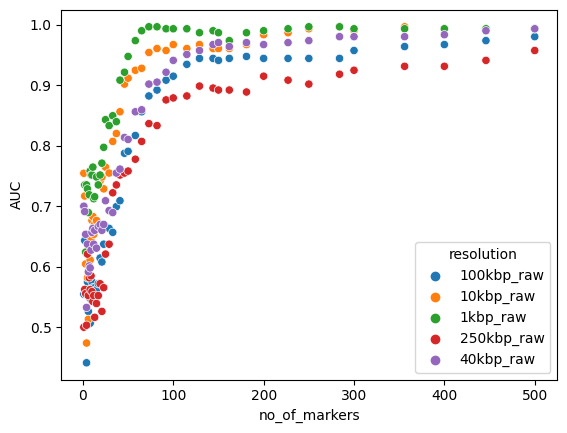

In [22]:
        sns.scatterplot(data=df.groupby(['resolution', 'dist', 'no_of_markers']).mean().reset_index(), x='no_of_markers', y='AUC', hue='resolution')
        #plt.xscale('log')
        plt.show()

In [ ]:
for process_type in ['intra']:
    for resolution in ['1kbp_raw']:
        for dist in [0,1,10,100,1000]:
            for species in ['mouse']:
                for marker_name in ['brain_class']:
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)



In [19]:
gc.collect()

3371

In [11]:
gc.collect()

2831

In [ ]:
for species in ['mouse']:
    for process_type in ['intra']:
        for resolution in ['1kbp_raw']:
            for dist in [0,1,10,100]:
                for marker_name in ['brain_class', 'brain_heart', 'heart']:
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)



In [ ]:
#stop this when human completes
#for species in ['mouse']:
#    for process_type in ['intra']:
        for resolution in ['40kbp_raw', '10kbp_raw',  '100kbp_raw']:
            for dist in [0,1,10,100]:
                for marker_name in ['brain_class', 'brain_blood', 'blood']:
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)

In [5]:

for species in ['human']:
    for process_type in ['inter']:
        for resolution in ['40kbp_raw', '10kbp_raw',  '100kbp_raw', '250kbp_raw']:
                for marker_name in ['brain_class', 'brain_heart', 'heart']:
                    dist=0
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)



<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

In [ ]:

for species in ['mouse']:
    for process_type in ['inter']:
        for resolution in ['40kbp_raw', '10kbp_raw',  '100kbp_raw', '250kbp_raw']:
                for marker_name in ['brain_class', 'brain_blood', 'blood']:
                    dist=0
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)


<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-3-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

In [3]:
for species in ['human']:
    for process_type in ['intra']:
        for resolution in ['40kbp_raw', '10kbp_raw',  '100kbp_raw']:
            for dist in [0,1,10,100]:
                for marker_name in ['brain_class', 'brain_heart', 'heart']:
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)

#stop this when human completes
#for species in ['mouse']:
#    for process_type in ['intra']:
        for resolution in ['40kbp_raw', '10kbp_raw',  '100kbp_raw']:
            for dist in [0,1,10,100]:
                for marker_name in ['brain_class', 'brain_blood', 'blood']:
                    layer_name = 'z_scores'
                    base_folder = '/grid/gillis/data_norepl/lohia/'
                    SRP_name='aggregates'
                    ice_type='KR'
                    input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                    if species=='mouse':
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                    else:
                        gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                    calc_mean_profile(marker_name, base_folder, species, input_file_h5ad, process_type,  ice_type, dist, layer_name)

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts
<ipython-input-2-464b8bfd5d6b>:55: RuntimeWarning: invalid value encountered in true_divide
  category_means = category_sums / category_counts

In [ ]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


#egad function

import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck


def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #print (nw_mask)
    nw = nw.loc[nw_mask, nw_mask].astype(float)
    #print (nw)
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)


def _runNV(go, nw, nFold=3, min_count=1, max_count=1000):

    #Make sure genes are same in go and nw
    genes_intersect = go.index.intersection(nw.index)

    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]

    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    
    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)


def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()
        
    CVgo = np.concatenate(list(cvgo.values()), axis=1)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)

    predicts = sumin / degree[:, None]

    np.place(predicts, CVgo > 0, np.nan)
    


    #Calculate ranks of positives
    #rank_abs = lambda x: stats.rankdata(np.abs(x))
    #predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    predicts2  = bottleneck.nanrankdata(abs(predicts), axis=0)


    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    


    filtering = np.tile(go, nFold)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)

    #Number of predictions
    #Number of 1's masked for each GO term for each CV
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn

    return roc, avg_degree, roc_null, P


tissue_dict = {'Chandelier': "brain",
 'Lamp5': "brain",
 'Lamp5_Lhx6': "brain",
 'Pax6': "brain",
 'Pvalb': "brain",
 'Sncg': "brain",
 'Sst': "brain",
 'Chandelier': "brain",
 'Sst Chodl': "brain",
 'Meis2': "brain",
 'Vip': "brain",
 'L2/3 IT': "brain",
 'L4 IT': "brain",
 'L5 ET': "brain",
 'L5 IT': "brain",
 'L5 PT': "brain",
 'L4/5 IT': "brain",
 'L5/6 NP': "brain",
 'L6 CT': "brain",
 'L6 IT': "brain",
 'L6 IT Car3': "brain",
 'L6b': "brain",
 'Astro': 'brain',
 'Endo': 'brain',
 'Micro-PVM': 'brain',
 'OPC': 'brain',
 'Oligo': "brain",
 'VLMC':'brain', 
 'Peri': 'brain',
 'SMC': 'brain',
 'T cell': 'heart',
 'basophil': 'heart',
 'erythroblast': 'heart',
 'granulocyte': 'heart',
 'hematopoietic precursor cell': 'heart',
 'immature B cell': 'heart',
 'immature natural killer cell': 'heart',
 'late pro-B cell': 'heart',
 'macrophage': 'heart',
 'monocyte': 'heart',
 'naive B cell': 'heart',
 'pro-B cell': 'heart',
 'proerythroblast' : 'heart',
 'Adipocytes' : 'heart',
 'Cardiomyocytes': 'heart',
 'Endocardial': 'heart',
 'Endothelial_Arterial': 'heart' ,
 'Endothelial_Capillaries': 'heart',
 'Endothelial_Other': 'heart',
 'Endothelial_Venous': 'heart',
 'Fibroblasts': 'heart',
 'Pericytes_Stromal': 'heart',
 'Smooth_Muscle_Cells': 'heart',
 'Pericytes': 'heart',
 'Epicardium_FB-like': 'heart',
 'Epicardium_Meso': 'heart',
 'Epicardium_Proliferating': 'heart',
 'Immature_Cardiomyocytes': 'heart',
 'Immature_other': 'heart',
 'Lymphoid_Immune_Cells': 'heart',
 'Myeloid_Immune_Cells': 'heart',
 'Neuronal_Cells': 'heart',}


NvsNN_dict = {'Chandelier': "N",
 'Lamp5': "N",
 'Lamp5_Lhx6': "N",
 'Pax6': "N",
 'Pvalb': "N",
 'Sncg': "N",
 'Sst': "N",
 'Chandelier': "N",
 'Sst Chodl': "N",
 'Meis2': "N",
 'Vip': "N",
 'L2/3 IT': "N",
 'L4 IT': "N",
 'L5 ET': "N",
 'L5 IT': "N",
 'L5 PT': "N",
 'L4/5 IT': "N",
 'L5/6 NP': "N",
 'L6 CT': "N",
 'L6 IT': "N",
 'L6 IT Car3': "N",
 'L6b': "N",
 'Astro': 'NN',
 'Endo': 'NN',
 'Micro-PVM': 'NN',
 'OPC': 'NN',
 'Oligo': "NN",
 'VLMC':'NN', 
 'Peri': 'NN',
 'SMC': 'NN',
}

GlutvsGaba_dict = {'Chandelier': "Gaba",
 'Lamp5': "Gaba",
 'Lamp5_Lhx6': "Gaba",
 'Pax6': "Gaba",
 'Pvalb': "Gaba",
 'Sncg': "Gaba",
 'Sst': "Gaba",
 'Chandelier': "Gaba",
 'Sst Chodl': "Gaba",
 'Meis2': "Gaba",
 'Vip': "Gaba",
 'L2/3 IT': "Glut",
 'L4 IT': "Glut",
 'L5 ET': "Glut",
 'L5 IT': "Glut",
 'L5 PT': "Glut",
 'L4/5 IT': "Glut",
 'L5/6 NP': "Glut",
 'L6 CT': "Glut",
 'L6 IT': "Glut",
 'L6 IT Car3': "Glut",
 'L6b': "Glut",
 }


def create_dict_from_columns(name_age_dict):
    # Create a dictionary from two columns of the DataFrame

    given_dict = name_age_dict.copy()
    
    n = len(given_dict.keys())
    tp_class = np.zeros((n, n))

    # Fill the diagonal elements with 1
    np.fill_diagonal(tp_class, 1)

    df_tp_class = pd.DataFrame(tp_class, index=given_dict.keys(), columns=given_dict.values())

    # Update the DataFrame based on the given_dict
    for key, value in given_dict.items():
        df_tp_class.loc[key, value] = 1

    # Remove duplicate columns
    df_tp_class = df_tp_class.loc[:, ~df_tp_class.columns.duplicated()]
    
    return df_tp_class

# Calculate the mean of genes for each category and observation, ignoring NaN values
def calculate_pearson_correlation(df_a, corr_method):
    # Calculate mean for each category (axis=0) and each observation (axis=1), ignoring NaN values


    df_corr = df_a.T.corr(min_periods=200, method=corr_method)
     
    return df_corr

# Call the function to calculate category means, ignoring NaN values



        

#for each marker-list and input file , I can make one output file

def calc_egad_vals(input_file_h5ad, outputfile_h5ad):

        

        adata = ad.read_h5ad(f'{input_file_h5ad}')
        
        np_of_col = len(adata.obs_names.tolist())
        np_of_rows = len(adata.obs_names.tolist())
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))
        
        layer_names = adata.layers.keys()    
        for corr_method in ['pearson']:
                        for given_layer in layer_names:



                                df_a = adata.to_df(layer=given_layer)

                                df_corr = calculate_pearson_correlation(df_a, corr_method)

                                l_n = f'{given_layer}_{corr_method}'

                                adata_l.layers[l_n] = df_corr

                                df_corr  = df_corr.fillna(0)
                                
                                df_corr += abs(df_corr.min().min())
                                
                                print (df_corr)

                                #df_list  = []
                                
                                if marker_name == 'brain_class':
                                    name_age_dict =  NvsNN_dict.copy()
                                    class_name = ['NvsNN']
                                else:
                                    name_age_dict =  tissue_dict.copy()
                                    class_name = 'tissue'

                                #for name_age_dict, class_name in zip([tissue_dict , NvsNN_dict], ['tissue' , 'NvsNN']):

                                df_tp_class = create_dict_from_columns(name_age_dict)

                                df_exp = run_egad(df_tp_class, df_corr)

                                #    df_list.append(df_exp)
                                #df_exp = pd.concat(df_list)

                                adata_l.uns[l_n] = df_exp



        adata_l.obs_names = adata.obs_names.tolist()
        adata_l.var_names = adata.obs_names.tolist()

        adata_l.write(outputfile_h5ad, compression="gzip")



In [ ]:


no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:

    for species in ['mouse']:
        for process_type in ['intra', 'inter']:
            for resolution in [ '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [True, False]:
                        for marker_name in ['brain_class', 'brain_blood']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_egad.h5ad'
                            calc_egad_vals(input_file_h5ad, outputfile_h5ad)


    for species in ['human']:
        for process_type in ['intra', 'inter']:
            for resolution in [ '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [True, False]:
                        for marker_name in ['brain_class', 'brain_heart']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_egad.h5ad'
                            calc_egad_vals(input_file_h5ad, outputfile_h5ad)





In [ ]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


#egad function

import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck




def calculate_pearson_correlation(df, df_b, corr_method):
    # Perform bin intersection
    bins_intersect = set(df.columns.tolist()).intersection(set(df_b.columns.tolist()))
    df = df.loc[:, bins_intersect]
    #df = df.fillna(0)
    #df_b = df_b.fillna(0)
    df_b = df_b.loc[:, bins_intersect]


    # Z-score normalization
    df_b_z = stats.zscore(df_b, axis=0, nan_policy='omit')
    df_b_z = pd.DataFrame(df_b_z, index=df_b.index.tolist(), columns=df_b.columns)
    df_b_z['cell_type'] = df_b_z.index.tolist()
    df_b_z = df_b_z.set_index(['cell_type'])

    df_z = stats.zscore(df, axis=0, nan_policy='omit')
    df_z = pd.DataFrame(df_z, index=df.index.tolist(), columns=df.columns)
    df_z['cell_type'] = df_z.index.tolist()
    df_z['cell_type'] = [x + '_hic' for x in df_z['cell_type']]
    df_z = df_z.set_index(['cell_type'])
    

    # Concatenate dataframes
    #print (df_b_z)
    #print (df_z)
    df_corr = pd.concat([df_b_z, df_z], axis=0)

    
    
    #df_corr = df_corr.dropna(axis=1, how='all')
    #df_corr = df_corr.dropna(axis=1)
    
    #df_corr = df_corr.set_index(['cell_type'])

            
    features_sc = stats.zscore(df_corr, axis=0, nan_policy='omit')
    
    #features_sc = features_sc.dropna(how='all', axis=1).fillna(0)
    
    #features_sc = features_sc.dropna(how='all', axis=1)
    
                
    df_dist_df = features_sc.T.corr(min_periods=10, method=corr_method)



    return df_dist_df


def calculate_auc_nan(df_dist_df, tp):
    df_jac_subset = df_dist_df.values
    df_exp_subset = tp.values

    coodinates_1 = np.where(np.isnan(df_jac_subset))
    coodinates_2 = np.where(np.isnan(df_exp_subset))

    x_coo = coodinates_1[0].tolist() + coodinates_2[0].tolist()
    y_coo = coodinates_1[1].tolist() + coodinates_2[1].tolist()

    df_jac_subset[x_coo, y_coo] = np.nan
    df_exp_subset[x_coo, y_coo] = np.nan

    predicts2 = bottleneck.nanrankdata(df_jac_subset, axis=1)

    tp = df_exp_subset.copy()
    tn = 1 - tp

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)

    df_auc = pd.DataFrame({'cell_type': df_dist_df.index.tolist(), 'AUC': auc_array})

    return df_auc

cell_type_map = {
 'Adipocyte' : 'Adipocytes',
 'Atrial Cardiomyocyte': 'Cardiomyocytes',
 'Ventricular Cardiomyocyte':'Immature_Cardiomyocytes',
 'Endothelial_Arterial': 'Endothelial' ,
 'Fibroblast': 'Fibroblasts',
 'Smooth Muscle': 'Smooth_Muscle_Cells',
 'Lymphocyte': 'Lymphoid_Immune_Cells',
 'Macrophage': 'Myeloid_Immune_Cells',
 'Nervous': 'Neuronal_Cells',}
        

#for each marker-list and input file , I can make one output file

def calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name):
    

        adata = ad.read_h5ad(f'{input_file_h5ad}', backed='r')
        adata_b = ad.read_h5ad(f'{input_file_another_exp_h5ad}', backed='r')
        df_b = adata_b.to_df()
        
        if marker_name == 'heart':
            df_b.index = [cell_type_map[x] for x in cell_type_map]

        df = adata.to_df()

        cell_type_intersect = df.index.intersection(df_b.index)


        df_b = df_b.loc[cell_type_intersect,:]
        

        np_of_col = len(cell_type_intersect)*2
        np_of_rows = len(cell_type_intersect)*2
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))

        
        layer_names = adata.layers.keys()    
        for corr_method in ['pearson']:
                        for given_layer in layer_names:
                        #for given_layer in accepted_layer_list:
                        
                        


                                df = adata.to_df(layer=given_layer)

                                df = df.loc[cell_type_intersect,:]

                                df_corr_real_names = calculate_pearson_correlation(df, df_b, corr_method)

                                l_n = f'{given_layer}_{corr_method}'

                                adata_l.layers[l_n] = df_corr_real_names

                                # Perform cell type intersection
                                #cell_type_intersect = df.index.intersection(df_b.index)

                                hic_cell_type = [x + '_hic' for x in cell_type_intersect]

                                df_corr = df_corr_real_names.loc[cell_type_intersect,:]
                            
                                df_corr = df_corr[hic_cell_type]

                                #df_corr  = df_corr.fillna(0)

                                #df_corr += abs(df_corr.min().min())

                                given_dict = dict(zip(df_corr.index.tolist(), df_corr.index.tolist()))

                                n = len(given_dict.keys())

                                tp_class = np.zeros((n, n))

                                # Fill the diagonal elements with 1
                                np.fill_diagonal(tp_class, 1)

                                df_tp_class = pd.DataFrame(tp_class, index=given_dict.keys(), columns=given_dict.values())

                                for key, value in given_dict.items():
                                    df_tp_class.loc[key, value] = 1
                            
                                df_tp_class = df_tp_class.loc[df_corr.index.tolist(), :]
                                    
                                    
                                df_exp = calculate_auc_nan(df_corr, df_tp_class)

                                adata_l.uns[l_n] = df_exp



        adata_l.obs_names = df_corr_real_names.index.tolist()
        adata_l.var_names = df_corr_real_names.columns.tolist()

        adata_l.write(outputfile_h5ad, compression="gzip")


In [ ]:

no_of_markers_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,17,19,21,23,25,29,33,37,41,46,50,58,65,73,82,92,100,115,129,144,150,162,181,200,227,250,284,300,356,400,446,500]     
for no_of_markers in no_of_markers_list:




    for species in ['mouse']:
        for process_type in ['intra']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                            for dist in [0,1,10,100]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)



    for species in ['mouse']:
        for process_type in ['inter']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                                dist = 0
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'                            
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/compartment.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_compartment.h5ad'
                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)








    for species in ['human']:
        for process_type in ['intra']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                            for dist in [0,1,10,100]:
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                marker_name = 'heart'

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_heart.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)




    for species in ['human']:
        for process_type in ['inter']:
            for resolution in ['250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
                for shuf in [True, False]:
                    for drop_duplicates in [False]:
                        for marker_name in ['brain_class']:
                                dist = 0
                                layer_name = 'z_scores'
                                base_folder = '/grid/gillis/data_norepl/lohia/'
                                SRP_name='aggregates'
                                ice_type='KR'
                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                                if species=='mouse':
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                                else:
                                    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_brain.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)

                                marker_name = 'heart'

                                input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean.h5ad'
                                input_file_another_exp_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/zemke_heart.h5ad'
                                outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_{no_of_markers}_by_allbins_max_mean_atac.h5ad'


                                calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name)



In [ ]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


#egad function

import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck




def calculate_pearson_correlation(df, df_b, corr_method):
    # Perform bin intersection
    bins_intersect = set(df.columns.tolist()).intersection(set(df_b.columns.tolist()))
    df = df.loc[:, bins_intersect]
    #df = df.fillna(0)
    #df_b = df_b.fillna(0)
    df_b = df_b.loc[:, bins_intersect]


    # Z-score normalization
    df_b_z = stats.zscore(df_b, axis=0, nan_policy='omit')
    df_b_z = pd.DataFrame(df_b_z, index=df_b.index.tolist(), columns=df_b.columns)
    df_b_z['cell_type'] = df_b_z.index.tolist()
    df_b_z = df_b_z.set_index(['cell_type'])

    df_z = stats.zscore(df, axis=0, nan_policy='omit')
    df_z = pd.DataFrame(df_z, index=df.index.tolist(), columns=df.columns)
    df_z['cell_type'] = df_z.index.tolist()
    df_z['cell_type'] = [x + '_hic' for x in df_z['cell_type']]
    df_z = df_z.set_index(['cell_type'])
    

    # Concatenate dataframes
    df_corr = pd.concat([df_b_z, df_z])

    
    
    #df_corr = df_corr.dropna(axis=1, how='all')
    #df_corr = df_corr.dropna(axis=1)
    
    #df_corr = df_corr.set_index(['cell_type'])

            
    features_sc = stats.zscore(df_corr, axis=0, nan_policy='omit')
    
    #features_sc = features_sc.dropna(how='all', axis=1).fillna(0)
    
    #features_sc = features_sc.dropna(how='all', axis=1)
    
                
    df_dist_df = features_sc.T.corr(min_periods=200, method=corr_method)



    return df_dist_df


def calculate_auc_nan(df_dist_df, tp):
    df_jac_subset = df_dist_df.values
    df_exp_subset = tp.values

    coodinates_1 = np.where(np.isnan(df_jac_subset))
    coodinates_2 = np.where(np.isnan(df_exp_subset))

    x_coo = coodinates_1[0].tolist() + coodinates_2[0].tolist()
    y_coo = coodinates_1[1].tolist() + coodinates_2[1].tolist()

    df_jac_subset[x_coo, y_coo] = np.nan
    df_exp_subset[x_coo, y_coo] = np.nan

    predicts2 = bottleneck.nanrankdata(df_jac_subset, axis=1)

    tp = df_exp_subset.copy()
    tn = 1 - tp

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)

    df_auc = pd.DataFrame({'cell_type': df_dist_df.index.tolist(), 'AUC': auc_array})

    return df_auc


        

#for each marker-list and input file , I can make one output file

def calc_pair_corr(input_file_h5ad_a, input_file_h5ad_b, file_b_species, outputfile_h5ad, resolution, base_folder, SRP_name):

        adata = ad.read_h5ad(f'{input_file_h5ad_a}', backed='r')
        adata_b = ad.read_h5ad(f'{input_file_h5ad_b}', backed='r')
        df_b = adata_b.to_df()

        df = adata.to_df()

        cell_type_intersect = df.index.intersection(df_b.index)




        species_input='mouse'
        species_output='human'
        
        if file_b_species == 'mouse':
            species_input='mouse'
            species_output='human'
        else:
            species_input='human'
            species_output='mouse'
        
        full_input_path = f'{base_folder}/hi_c_data_processing/data_{species_input}/{SRP_name}/{resolution}/max/'
        
        full_target_path = f'{base_folder}/hi_c_data_processing/data_{species_output}/{SRP_name}/{resolution}/max/'
        if species_input=='mouse':
            chain_file = 'mm10ToHg38.over.chain.gz'
        else:
            chain_file = 'hg38ToMm10.over.chain.gz'
        for minmatch in [0.5]:

            os.system(f"{base_folder}/hi_c_data_processing/software/liftOver -minMatch={minmatch} {full_input_path}/regions_bed_file.tsv {base_folder}/hi_c_data_processing/software/{chain_file} {full_input_path}/minmatch{minmatch}_{species_input}_to_{species_output}.bed u")

            os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {full_input_path}/minmatch{minmatch}_{species_input}_to_{species_output}.bed -a {full_target_path}/regions_bed_file.tsv > {full_target_path}/minmatch{minmatch}_{species_input}_to_{species_output}_matched.bed")

            if species_output=='human':

                df_human_mouse_bins = pd.read_csv(f'{full_target_path}/minmatch{minmatch}_{species_input}_to_{species_output}_matched.bed', sep='\t', names=['a', 'b', 'c', 'human_bin', 'a1', 'b1', 'c1', 'mouse_bin', 'overlap'])
            else:
                df_human_mouse_bins = pd.read_csv(f'{full_target_path}/minmatch{minmatch}_{species_input}_to_{species_output}_matched.bed', sep='\t', names=['a', 'b', 'c', 'mouse_bin', 'a1', 'b1', 'c1', 'human_bin', 'overlap'])

        #correct bin_id to correct bin_id

        df_human_mouse_bins['mouse_bin'] = [f"bin_{i}" for i in df_human_mouse_bins['mouse_bin'].tolist()]
        df_human_mouse_bins['human_bin'] = [f"bin_{i}" for i in df_human_mouse_bins['human_bin'].tolist()]


        dk_human = df.copy()
        dk_mouse = df_b.copy()

        df_human_mouse_bins  = df_human_mouse_bins[df_human_mouse_bins['mouse_bin'].isin(dk_mouse.T.index.tolist())]
        df_human_mouse_bins  = df_human_mouse_bins[df_human_mouse_bins['human_bin'].isin(dk_human.T.index.tolist())]
                

        np_of_col = len(cell_type_intersect)*2
        np_of_rows = len(cell_type_intersect)*2
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))

        
        layer_names = adata.layers.keys()    
        for corr_method in ['pearson']:
                        for given_layer in layer_names:


                                df = adata.to_df(layer=given_layer)

                                df = df.loc[cell_type_intersect,:]

                                df_b = adata_b.to_df(layer=given_layer)

                                df_b = df_b.loc[cell_type_intersect,:]


                                df = df.loc[:,df_human_mouse_bins['human_bin'].tolist()]

                                df = df.T
                                df.index = df_human_mouse_bins['mouse_bin'].tolist()
                                df = df.T
                                df_b = df_b.loc[:,df_human_mouse_bins['mouse_bin'].tolist()]




                                df_corr_real_names = calculate_pearson_correlation(df, df_b, corr_method)

                                l_n = f'{given_layer}_{corr_method}'

                                adata_l.layers[l_n] = df_corr_real_names

                                # Perform cell type intersection
                                #cell_type_intersect = df.index.intersection(df_b.index)

                                hic_cell_type = [x + '_hic' for x in cell_type_intersect]

                                df_corr = df_corr_real_names.loc[cell_type_intersect,:]
                            
                                df_corr = df_corr[hic_cell_type]

                                #df_corr  = df_corr.fillna(0)

                                #df_corr += abs(df_corr.min().min())

                                given_dict = dict(zip(df_corr.index.tolist(), df_corr.index.tolist()))

                                n = len(given_dict.keys())

                                tp_class = np.zeros((n, n))

                                # Fill the diagonal elements with 1
                                np.fill_diagonal(tp_class, 1)

                                df_tp_class = pd.DataFrame(tp_class, index=given_dict.keys(), columns=given_dict.values())

                                for key, value in given_dict.items():
                                    df_tp_class.loc[key, value] = 1
                            
                                df_tp_class = df_tp_class.loc[df_corr.index.tolist(), :]
                                    
                                    
                                df_exp = calculate_auc_nan(df_corr, df_tp_class)

                                adata_l.uns[l_n] = df_exp



        adata_l.obs_names = df_corr_real_names.index.tolist()
        adata_l.var_names = df_corr_real_names.columns.tolist()

        adata_l.write(outputfile_h5ad, compression="gzip")


base_folder = '/grid/gillis/data_norepl/lohia/'
species='human'
resolution='500kbp_raw'
SRP_name='aggregates'
process_type='intra'
ice_type='KR'
input_file_h5ad=f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_by_allbins_max.h5ad'
if species=='mouse':
    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
else:
    gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 
    
    


dist=0
layer_name = 'z_scores'
input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'


marker_name = 'brain_class'
drop_duplicates = True
shuf = False



In [ ]:





for species in ['mouse']:
    for process_type in ['intra']:
        for resolution in ['500kbp_raw', '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
            for shuf in [True, False]:
                for drop_duplicates in [False]:
                    for marker_name in ['brain_class']:
                        for dist in [0,1,10,100]:
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 


                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean_cross_species.h5ad'

                            if species == 'human':
                                species_b = 'mouse'
                            input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'

                            calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)





for species in ['mouse']:
    for process_type in ['inter']:
        for resolution in ['500kbp_raw', '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
            for shuf in [True, False]:
                for drop_duplicates in [False]:
                    for marker_name in ['brain_class']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean_cross_species.h5ad'

                            if species == 'human':
                                species_b = 'mouse'
                            input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'

                            calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)







for species in ['human']:
    for process_type in ['intra']:
        for resolution in ['500kbp_raw', '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
            for shuf in [True, False]:
                for drop_duplicates in [False]:
                    for marker_name in ['brain_class']:
                        for dist in [0,1,10,100]:
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean_cross_species.h5ad'

                            if species == 'human':
                                species_b = 'mouse'
                            input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'

                            calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)



for species in ['human']:
    for process_type in ['inter']:
        for resolution in ['500kbp_raw', '250kbp_raw', '100kbp_raw', '40kbp_raw', '10kbp_raw']:
            for shuf in [True, False]:
                for drop_duplicates in [False]:
                    for marker_name in ['brain_class']:
                            dist = 0
                            layer_name = 'z_scores'
                            base_folder = '/grid/gillis/data_norepl/lohia/'
                            SRP_name='aggregates'
                            ice_type='KR'
                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{process_type}_{dist}_{layer_name}_by_allbins_max.h5ad'
                            if species=='mouse':
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
                            else:
                                gene_annot_file=f'{base_folder}/hi_c_data_processing/genomes_jlee/gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz' 

                            input_file_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'
                            outputfile_h5ad = f'{base_folder}/hi_c_data_processing/data_{species}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean_cross_species.h5ad'

                            if species == 'human':
                                species_b = 'mouse'
                            input_file_h5ad_b = f'{base_folder}/hi_c_data_processing/data_{species_b}/aggregates/{resolution}/max/hic_gene_{process_type}_{ice_type}_{dist}_{layer_name}_{drop_duplicates}_{shuf}_{marker_name}_by_allbins_max_mean.h5ad'

                            calc_pair_corr(input_file_h5ad, input_file_h5ad_b, species_b, outputfile_h5ad, resolution, base_folder, SRP_name)


In [ ]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc


#egad function

import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck




def calculate_pearson_correlation(df, df_b, corr_method):
    # Perform bin intersection
    bins_intersect = set(df.columns.tolist()).intersection(set(df_b.columns.tolist()))
    df = df.loc[:, bins_intersect]
    #df = df.fillna(0)
    #df_b = df_b.fillna(0)
    df_b = df_b.loc[:, bins_intersect]


    # Z-score normalization
    df_b_z = stats.zscore(df_b, axis=0, nan_policy='omit')
    df_b_z = pd.DataFrame(df_b_z, index=df_b.index.tolist(), columns=df_b.columns)
    df_b_z['cell_type'] = df_b_z.index.tolist()
    df_b_z = df_b_z.set_index(['cell_type'])

    df_z = stats.zscore(df, axis=0, nan_policy='omit')
    df_z = pd.DataFrame(df_z, index=df.index.tolist(), columns=df.columns)
    df_z['cell_type'] = df_z.index.tolist()
    df_z['cell_type'] = [x + '_hic' for x in df_z['cell_type']]
    df_z = df_z.set_index(['cell_type'])
    

    # Concatenate dataframes
    #print (df_b_z)
    #print (df_z)
    df_corr = pd.concat([df_b_z, df_z], axis=0)

    
    
    #df_corr = df_corr.dropna(axis=1, how='all')
    #df_corr = df_corr.dropna(axis=1)
    
    #df_corr = df_corr.set_index(['cell_type'])

            
    features_sc = stats.zscore(df_corr, axis=0, nan_policy='omit')
    
    #features_sc = features_sc.dropna(how='all', axis=1).fillna(0)
    
    #features_sc = features_sc.dropna(how='all', axis=1)
    
                
    df_dist_df = features_sc.T.corr(min_periods=10, method=corr_method)



    return df_dist_df


def calculate_auc_nan(df_dist_df, tp):
    df_jac_subset = df_dist_df.values
    df_exp_subset = tp.values

    coodinates_1 = np.where(np.isnan(df_jac_subset))
    coodinates_2 = np.where(np.isnan(df_exp_subset))

    x_coo = coodinates_1[0].tolist() + coodinates_2[0].tolist()
    y_coo = coodinates_1[1].tolist() + coodinates_2[1].tolist()

    df_jac_subset[x_coo, y_coo] = np.nan
    df_exp_subset[x_coo, y_coo] = np.nan

    predicts2 = bottleneck.nanrankdata(df_jac_subset, axis=1)

    tp = df_exp_subset.copy()
    tn = 1 - tp

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1))) - (np.nansum(tp, axis=1) + 1) / 2)) / np.nansum(tn, axis=1)

    df_auc = pd.DataFrame({'cell_type': df_dist_df.index.tolist(), 'AUC': auc_array})

    return df_auc

cell_type_map = {
 'Adipocyte' : 'Adipocytes',
 'Atrial Cardiomyocyte': 'Cardiomyocytes',
 'Ventricular Cardiomyocyte':'Immature_Cardiomyocytes',
 'Endothelial_Arterial': 'Endothelial' ,
 'Fibroblast': 'Fibroblasts',
 'Smooth Muscle': 'Smooth_Muscle_Cells',
 'Lymphocyte': 'Lymphoid_Immune_Cells',
 'Macrophage': 'Myeloid_Immune_Cells',
 'Nervous': 'Neuronal_Cells',}
        

#for each marker-list and input file , I can make one output file

def calc_pair_corr(input_file_h5ad, input_file_another_exp_h5ad, outputfile_h5ad, marker_name):
    

        adata = ad.read_h5ad(f'{input_file_h5ad}', backed='r')
        adata_b = ad.read_h5ad(f'{input_file_another_exp_h5ad}', backed='r')
        df_b = adata_b.to_df()
        
        if marker_name == 'heart':
            df_b.index = [cell_type_map[x] for x in cell_type_map]

        df = adata.to_df()

        cell_type_intersect = df.index.intersection(df_b.index)


        df_b = df_b.loc[cell_type_intersect,:]
        

        np_of_col = len(cell_type_intersect)*2
        np_of_rows = len(cell_type_intersect)*2
        
        adata_l = ad.AnnData(np.zeros((np_of_rows, np_of_col)))

        
        layer_names = adata.layers.keys()    
        for corr_method in ['pearson']:
                        for given_layer in layer_names:
                        #for given_layer in accepted_layer_list:
                        
                        


                                df = adata.to_df(layer=given_layer)

                                df = df.loc[cell_type_intersect,:]

                                df_corr_real_names = calculate_pearson_correlation(df, df_b, corr_method)

                                l_n = f'{given_layer}_{corr_method}'

                                adata_l.layers[l_n] = df_corr_real_names

                                # Perform cell type intersection
                                #cell_type_intersect = df.index.intersection(df_b.index)

                                hic_cell_type = [x + '_hic' for x in cell_type_intersect]

                                df_corr = df_corr_real_names.loc[cell_type_intersect,:]
                            
                                df_corr = df_corr[hic_cell_type]

                                #df_corr  = df_corr.fillna(0)

                                #df_corr += abs(df_corr.min().min())

                                given_dict = dict(zip(df_corr.index.tolist(), df_corr.index.tolist()))

                                n = len(given_dict.keys())

                                tp_class = np.zeros((n, n))

                                # Fill the diagonal elements with 1
                                np.fill_diagonal(tp_class, 1)

                                df_tp_class = pd.DataFrame(tp_class, index=given_dict.keys(), columns=given_dict.values())

                                for key, value in given_dict.items():
                                    df_tp_class.loc[key, value] = 1
                            
                                df_tp_class = df_tp_class.loc[df_corr.index.tolist(), :]
                                    
                                    
                                df_exp = calculate_auc_nan(df_corr, df_tp_class)

                                adata_l.uns[l_n] = df_exp



        adata_l.obs_names = df_corr_real_names.index.tolist()
        adata_l.var_names = df_corr_real_names.columns.tolist()

        adata_l.write(outputfile_h5ad, compression="gzip")


In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import os.path
import gc
import os
import matplotlib.pyplot as plt
from pyranges import read_gtf


from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import seaborn as sns


import anndata as ad
import scanpy as sc

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
base_folder = '/grid/gillis/data_norepl/lohia/'
species='mouse'
resolution='1kbp_raw'
SRP_name='aggregates'
input_file_h5ad='/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/hic_gene_gw_none_by_allbins_max.h5ad'
gene_annot_file='/grid/gillis/data_norepl/lohia/hi_c_data_processing/genomes_jlee/Mus_musculus.GRCm38.94.gtf.gz'
process_type='gw'

In [6]:
    bins_bed = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.csv', names=['chr', 'start', 'end'])
    bins_bed['bin_id'] = bins_bed.index.tolist()

    bins_bed.to_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv', index=False, header=False, sep='\t')
    if species == 'human':

        blacklist_file = f'{base_folder}/BICCN_enhancer_challenege/10XMultiome/Human/hg38-blacklist.v2.bed'
    else:
        blacklist_file = f'{base_folder}/BICCN_enhancer_challenege/10XMultiome/Mouse/mm10-blacklist.v2.bed'

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {blacklist_file} -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv > {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bin_blacklist.bed")
    blacklist_bins = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bin_blacklist.bed', sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'c1', 'c2', 'c3', 'c4'])
    

In [9]:
adata = ad.read_h5ad(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/1kbp_raw/max/hic_gene_intra_KR_by_allbins_max.h5ad')



In [4]:
    data = adata.X + 0.0
    
    if resolution == '1kbp_raw':
    
        data = data.astype('float32')
        
    elif resolution == '10kbp_raw':
    
        data = data.astype('float32')
    else:
        data = data.astype('float64')

        
    
    nan_columns = blacklist_bins['bin_id'].tolist()

    data[:, nan_columns] = np.nan


    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()

    chrom_index_list  = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])

        chrom_index_list_intra[chrom] = index_list

    gtf = read_gtf(gene_annot_file)
    genes = gtf.df.loc[gtf.df['Feature'] == 'gene'].copy()
    genes['gene_id'] = [x.split('.')[0] for x in genes['gene_id']]
    genes['gene_id'].drop_duplicates(inplace=True)

    if not genes['Chromosome'].str.startswith('chr').any():
        genes['Chromosome'] = [f'chr{x}' for x in genes['Chromosome']]

    genes  = genes.set_index('gene_id')

    genes = genes.loc[adata.obs_names.tolist(), :]
    
    genes = genes.reset_index()



    genes[['Chromosome', 'Start', 'End', 'gene_id']].to_csv(f'{base_folder}hi_c_data_processing/data_{species}/gene_info.tsv', index=False, header=False, sep='\t')


    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {base_folder}hi_c_data_processing/data_{species}/gene_info.tsv -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/regions_bed_file.tsv > {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/gene_info_bin_id.tsv")
    gene_id_bins = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/gene_info_bin_id.tsv', sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'st', 'end', 'gene_id', 'c4'])

    


NameError: name 'adata' is not defined

In [14]:
    if process_type == 'intra':

        layer_value_list = [0, 1, 10, 100, 1000]
        layer_name_list = ['intra']*len(layer_value_list)

    if process_type == 'inter':
        layer_name_list = ['inter']
        layer_value_list = [0]

    if process_type == 'gw':
        layer_value_list = [0, 1, 10, 100, 1000]
        layer_name_list = ['intra']*len(layer_value_list)
        layer_name_list.append('inter')
        layer_value_list.append(0)



    for layer_type, dist in zip(layer_name_list, layer_value_list):
        
        new_layer_name = f'{process_type}_{layer_type}_{dist}'
        
        if new_layer_name in adata.layers:
            continue
        else:

            mask = np.zeros_like(data, dtype=bool)

        

            for index, row in genes.iterrows():

                if layer_type == 'intra':
                    columns_to_mask = chrom_index_list_intra[row['Chromosome']]
                else:
                    columns_to_mask = chrom_index_list[row['Chromosome']]

                mask[index, columns_to_mask] = True

                if layer_type == 'intra':

                    start_index = gene_id_bins[gene_id_bins['gene_id'] == row['gene_id']]['bin_id'].min()

                    end_index = gene_id_bins[gene_id_bins['gene_id'] == row['gene_id']]['bin_id'].max()

                    mask[index, start_index:end_index+1]  = True

                    #for idx in [start_index, end_index]:
                    mask[index, max(0, start_index - dist):min(data.shape[1], end_index + dist+1)] = True




            data_layered = np.where(mask, np.nan, data)



            layer_name = f'{process_type}_{layer_type}_{dist}'

            adata.layers[layer_name] = data_layered

            z_scores = stats.zscore(data_layered, axis=1, nan_policy='omit')


            clipped_z_scores = np.clip(z_scores, -10, 10)



            layer_name = f'{process_type}_{layer_type}_{dist}_z_scores'

            adata.layers[layer_name] = clipped_z_scores



            del z_scores
            del clipped_z_scores
            gc.collect()

            #data_plus_one = data_layered + 1

            #log_transformed_data = np.log1p(data_plus_one)

            del data_layered
            #del data_plus_one
            gc.collect()

            #layer_name = f'{process_type}_{layer_type}_{dist}_log_transformed'

            #adata.layers[layer_name] = log_transformed_data

            #z_scores = stats.zscore(log_transformed_data, axis=1, nan_policy='omit')

            #clipped_z_scores = np.clip(z_scores, -10, 10)



            #layer_name = f'{process_type}_{layer_type}_{dist}_log_transformed_z_scores'

            #adata.layers[layer_name] = clipped_z_scores

            #del z_scores
            #del log_transformed_data
            #del clipped_z_scores
            #gc.collect()

            adata.write(f'{input_file_h5ad}', compression="gzip")

RuntimeError: Can't get creation plist (bad object header version number)

Above error raised while writing key 'gw_intra_0' of <class 'h5py._hl.group.Group'> to /

In [ ]:
if [[ "$species" == "human" ]]
then
CHROMS=/grid/gillis/data_norepl/nfox/genomes/homo_sapiens_38/hg38.chrom.sizes 
chrom_list="chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chr20,chr21,chr22"
chrom_list_2="chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22"
GENOME="gencode.v28.chr_patch_hapl_scaff.annotation.gtf.gz"
EXP_NETWORKS="human_prioAggNet.hdf5"

elif [[ "$species" == "mouse" ]]
then
CHROMS=/grid/gillis/data_norepl/nfox/genomes/mus_musculus_10/mm10.chrom.sizes
GENOME="Mus_musculus.GRCm38.94.gtf.gz"
EXP_NETWORKS="mouse_prioAggNet.hdf5"
chrom_list="chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19"
chrom_list_2="chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19"


In [ ]:
add_layers_anndata(process_type, input_file_h5ad, gene_annot_file, species, SRP_name, resolution, base_folder)



In [ ]:

ice_type='none'

base_path='/grid/gillis/data_norepl/lohia/'


        
    python ${software_path}/add_contact_norm_layers.py \
    --process_type ${process} \
    --species ${species} \
    --input_file_h5ad /grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/10kbp_raw/max/hic_gene_gw_none_by_allbins_max.h5ad \
    --base_path $base_path \
    --resolution $NETWORK \
    --SRP $SRP_name \
    --gene_annot_file ${base_folder}/lohia/hi_c_data_processing/genomes_jlee/${GENOME}
    

